## Necessary Imports

In [1]:
import math
import os
import json

import tensorflow as tf
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

RANDOM_SEED = 0

2022-04-27 13:19:56.546643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 13:19:56.546681: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Helper Function Definitions

In [2]:
def print_report(y_test, y_pred):
  print("Accuracy Score is:\t {0:.3f}".format(accuracy_score(y_test, y_pred)))
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

In [3]:
def load_data(data_path):
    
    with open(data_path,"r") as fp:
        data = json.load(fp)
    
    genres = data['mapping']
    mfcc = np.array(data['mfcc'])
    features = np.array(data['features'])
    y = np.array(data["labels"])
    
    return genres, mfcc, features, y

In [4]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error subplot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

In [5]:
def prepare_datasets(X_train, y_train, validation_size):
    ##### CNN Specific Dataloader #####
    
    # create train, validation and test split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]

    return X_train, X_val, y_train, y_val

In [6]:
def replace_intermediate_layer_in_keras(model, layer_id, new_layer):
    
    layers = [l for l in model.layers]

    x = layers[0].output
    for i in range(1, len(layers)):
        if i == layer_id:
            x = new_layer(x)
        else:
            x = layers[i](x)

    new_model = keras.models.Model(layers[0].input, x)
    return new_model

In [7]:
def predict_genre(model, song_mfcc, y_true):
    """
    Given a song, predict it's label (using a keras model)
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    song_mfcc = song_mfcc[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(song_mfcc)

    # get index with max value
    y_pred = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y_true, y_pred))

In [18]:
def build_multimodal_mlp(INPUT_SHAPE):
#     model = keras.Sequential([

#         # input layer
#         keras.layers.Dense(INPUT_SHAPE, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#         keras.layers.Dropout(0.3),

#         # 1st dense layer
#         keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#         keras.layers.Dropout(0.3),

#         # 2nd dense layer
#         keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
#         keras.layers.Dropout(0.3),

#     ])

    model = keras.Sequential()
    
    # input layer
    model.add(keras.layers.InputLayer(input_shape=INPUT_SHAPE))
    
    # 1st dense layer
    model.add(keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.3))
    
    # 2nd dense layer
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.3))
    
    # 3rd dense layer
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.3))
    
    return model

In [9]:
def build_multimodal_cnn(INPUT_SHAPE):

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())


    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    return model

## Load Data & Develop Test/Train Splits

In [10]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_data.json"
GTZAN_JSON_PATH = "/storage/graham/music/gtzan.json"
MULTIMODAL_PATH = "/storage/graham/music/fma_small_echonest.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [11]:
%%time
genres, mfcc, features, y = load_data(MULTIMODAL_PATH)

CPU times: user 25.3 s, sys: 1.97 s, total: 27.3 s
Wall time: 27.3 s


In [13]:
SPLIT = 0.3

# create train/test split
mfcc_train, mfcc_test, _, _  = train_test_split(mfcc, y, test_size=SPLIT, random_state=RANDOM_SEED)
x_train, x_test, y_train, y_test = train_test_split(features, y, test_size=SPLIT, random_state=RANDOM_SEED)

# reshape MFCC to be a vector
mfcc_train_vec = mfcc_train.reshape(mfcc_train.shape[0], mfcc_train.shape[1]*mfcc_train.shape[2])
mfcc_test_vec = mfcc_test.reshape(mfcc_test.shape[0], mfcc_test.shape[1]*mfcc_test.shape[2])

mfcc_vec = mfcc.reshape(mfcc.shape[0], mfcc.shape[1]*mfcc.shape[2])

## Multi-Modal Model

In [14]:
VALIDATION_SPLIT = 0.3

# create train, validation andtest split
mfcc_train, mfcc_val, _, _  = train_test_split(mfcc_train, y_train, test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=VALIDATION_SPLIT, random_state=RANDOM_SEED)

# add an axis to input sets
mfcc_train = mfcc_train[..., np.newaxis]
mfcc_val = mfcc_val[..., np.newaxis]

cnn_input_shape = (mfcc_train.shape[1], mfcc_train.shape[2], 1)
mlp_input_shape = x_train.shape[1]

In [28]:
mlp = build_multimodal_mlp(mlp_input_shape)
cnn = build_multimodal_cnn(cnn_input_shape)

x = keras.layers.Concatenate()([mlp.output, cnn.output])

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)

x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Dense(len(genres), activation="softmax")(x)

model = keras.Model(inputs=[mlp.input, cnn.input], outputs=x)

OPTIMIZER = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'],
              optimizer=OPTIMIZER)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 conv2d_15_input (InputLayer)   [(None, 259, 13, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 257, 11, 32)  320         ['conv2d_15_input[0][0]']        
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 129, 6, 32)  0           ['conv2d_15[0][0]']              
 )                                                                                                
                                                                                            

Epoch 1/30
188/188 [==============================] - 5s 23ms/step - loss: 2.4964 - accuracy: 0.2606 - val_loss: 1.9839 - val_accuracy: 0.3980
Epoch 2/30
188/188 [==============================] - 5s 26ms/step - loss: 1.9781 - accuracy: 0.3898 - val_loss: 1.8087 - val_accuracy: 0.4365
Epoch 3/30
188/188 [==============================] - 5s 27ms/step - loss: 1.7837 - accuracy: 0.4372 - val_loss: 1.5816 - val_accuracy: 0.5074
Epoch 4/30
188/188 [==============================] - 4s 24ms/step - loss: 1.6774 - accuracy: 0.4664 - val_loss: 1.5979 - val_accuracy: 0.4794
Epoch 5/30
188/188 [==============================] - 5s 25ms/step - loss: 1.5708 - accuracy: 0.4958 - val_loss: 1.5375 - val_accuracy: 0.5312
Epoch 6/30
188/188 [==============================] - 5s 27ms/step - loss: 1.5171 - accuracy: 0.5152 - val_loss: 1.5377 - val_accuracy: 0.5218
Epoch 7/30
188/188 [==============================] - 5s 25ms/step - loss: 1.4601 - accuracy: 0.5369 - val_loss: 1.3765 - val_accuracy: 0.5615

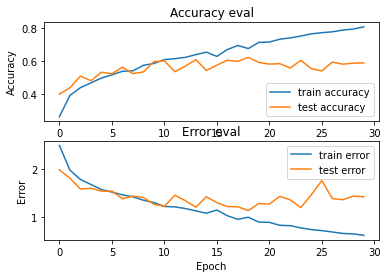

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [29]:
# train model
history = model.fit([x_train, mfcc_train], y_train, validation_data=([x_val, mfcc_val], y_val), batch_size=32, epochs=30)

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate([x_test, mfcc_test], y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# save model
model.save(MODEL_PATH + "/multimodal/")

# TODO: Add Benchmarks for this dataset